In [11]:
import pandas as pd
import numpy as np
import time
import requests
import matplotlib.pyplot as plt
import terminalLogic
from terminalLogic import Algo
import client
from client import engine

from typing import Optional, Dict, Any, List
from ciso8601 import parse_datetime
from requests import Request, Session, Response
import sys
import hmac
import urllib.parse
import time
import plotly.graph_objects as go
from ta import add_all_ta_features
from ta.utils import dropna
from datetime import datetime
plt.rcParams["figure.figsize"] = (100,10)


In [43]:
moms = [('kim Ray',
         'Kim B',
         'Blah Blah')]
print(moms)

[('kim Ray', 'Kim B', 'Blah Blah')]


In [12]:
# df = pd.read_csv('data/btc1m.csv')

In [13]:
# btc = FtxClient()
# df = btc.get_all_markets('BTC-PERP')

In [14]:
# db=pd.json_normalize(df)

# db.to_csv('data/btc1m.csv')

In [19]:
df = pd.read_csv('minute.csv')

In [20]:
# df[::-1]
df = df.drop(df.columns[0], axis = 1) 
df = df[::-1]
df

,startTime,time,open,high,low,close,volume,9-min,21-min,signal,market_returns,trend_returns,entry,ma,ratio,position,entryR,range_returns,sign
478,2021-10-11T19:11:00+00:00,1.633979e+12,57475.0,57475.0,57475.0,57475.0,0.000000e+00,57466.444444,57436.619048,1.0,0.000000,0.000122,0.0,57466.444444,1.000149,-1.0,0.0,-0.000000,1.0
477,2021-10-11T19:10:00+00:00,1.633979e+12,57468.0,57484.0,57456.0,57475.0,1.639250e+05,57468.222222,57430.095238,1.0,0.000122,-0.000070,0.0,57468.222222,1.000118,-1.0,0.0,-0.000122,1.0
476,2021-10-11T19:09:00+00:00,1.633979e+12,57472.0,57472.0,57452.0,57468.0,3.304647e+04,57456.888889,57425.428571,1.0,-0.000070,-0.000452,0.0,57456.888889,1.000193,-1.0,0.0,0.000070,-1.0
475,2021-10-11T19:08:00+00:00,1.633979e+12,57498.0,57499.0,57472.0,57472.0,1.159492e+05,57444.111111,57421.095238,1.0,-0.000452,-0.000574,0.0,57444.111111,1.000485,-1.0,0.0,0.000452,-1.0
474,2021-10-11T19:07:00+00:00,1.633979e+12,57531.0,57536.0,57497.0,57498.0,2.241915e+05,57433.666667,57415.714286,1.0,-0.000574,0.000713,0.0,57433.666667,1.001120,-1.0,0.0,0.000574,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-10-11T11:17:00+00:00,1.633951e+12,56121.0,56200.0,56121.0,56197.0,1.446364e+06,56062.333333,56193.571429,-1.0,0.001353,0.000160,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-10-11T11:16:00+00:00,1.633951e+12,56130.0,56150.0,56088.0,56121.0,2.464810e+05,56073.444444,56205.000000,-1.0,-0.000160,-0.001248,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-10-11T11:15:00+00:00,1.633951e+12,56060.0,56130.0,56056.0,56130.0,4.376744e+05,56090.111111,56219.095238,-1.0,0.001248,-0.002411,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-11T11:14:00+00:00,1.633951e+12,55925.0,56060.0,55925.0,56060.0,2.326389e+06,56117.222222,56237.666667,-1.0,0.002411,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df["ma"] = df['close'].rolling(9).mean()
df['ratio'] = df['close'] / df['ma']
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(df['ratio'].dropna(), percentiles)
short = p[-1]
long = p[0]
df['position'] = np.where(df.ratio > short, -1, np.nan)
df['position'] = np.where(df.ratio < long, 1, df['position'])
df['position'] = df['position'].ffill()
df['returns'] = np.log(df["close"]).diff()
df['strat_return'] = df['returns'] * df['position'].shift()
df

,startTime,time,open,high,low,close,volume,9-min,21-min,signal,...,trend_returns,entry,ma,ratio,position,entryR,range_returns,sign,returns,strat_return
478,2021-10-11T19:11:00+00:00,1.633979e+12,57475.0,57475.0,57475.0,57475.0,0.000000e+00,57466.444444,57436.619048,1.0,...,0.000122,0.0,NaN,NaN,NaN,0.0,-0.000000,1.0,NaN,NaN
477,2021-10-11T19:10:00+00:00,1.633979e+12,57468.0,57484.0,57456.0,57475.0,1.639250e+05,57468.222222,57430.095238,1.0,...,-0.000070,0.0,NaN,NaN,NaN,0.0,-0.000122,1.0,0.000000,NaN
476,2021-10-11T19:09:00+00:00,1.633979e+12,57472.0,57472.0,57452.0,57468.0,3.304647e+04,57456.888889,57425.428571,1.0,...,-0.000452,0.0,NaN,NaN,NaN,0.0,0.000070,-1.0,-0.000122,NaN
475,2021-10-11T19:08:00+00:00,1.633979e+12,57498.0,57499.0,57472.0,57472.0,1.159492e+05,57444.111111,57421.095238,1.0,...,-0.000574,0.0,NaN,NaN,NaN,0.0,0.000452,-1.0,0.000070,NaN
474,2021-10-11T19:07:00+00:00,1.633979e+12,57531.0,57536.0,57497.0,57498.0,2.241915e+05,57433.666667,57415.714286,1.0,...,0.000713,0.0,NaN,NaN,NaN,0.0,0.000574,1.0,0.000452,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-10-11T11:17:00+00:00,1.633951e+12,56121.0,56200.0,56121.0,56197.0,1.446364e+06,56062.333333,56193.571429,-1.0,...,0.000160,0.0,56211.444444,0.999743,1.0,NaN,NaN,NaN,0.000036,0.000036
3,2021-10-11T11:16:00+00:00,1.633951e+12,56130.0,56150.0,56088.0,56121.0,2.464810e+05,56073.444444,56205.000000,-1.0,...,-0.001248,0.0,56194.222222,0.998697,1.0,NaN,NaN,NaN,-0.001353,-0.001353
2,2021-10-11T11:15:00+00:00,1.633951e+12,56060.0,56130.0,56056.0,56130.0,4.376744e+05,56090.111111,56219.095238,-1.0,...,-0.002411,0.0,56181.111111,0.999090,1.0,NaN,NaN,NaN,0.000160,0.000160
1,2021-10-11T11:14:00+00:00,1.633951e+12,55925.0,56060.0,55925.0,56060.0,2.326389e+06,56117.222222,56237.666667,-1.0,...,NaN,0.0,56164.444444,0.998140,1.0,NaN,NaN,NaN,-0.001248,-0.001248


In [22]:
#column for negative and positive
df.dropna()
df['sign'] = np.where(df['strat_return'] < 0, 'neg','pos')
#consecutive groups
df['series'] = df['sign'].ne(df['sign'].shift()).cumsum()
#removed groups with length more like 2
df = df[df['series'].map(df['series'].value_counts()).gt(2)]
#tested if order `pos-neg` of groups, if not removed groups
m1 = df['sign'].eq('pos') & df['sign'].shift(-1).eq('neg')
m2 = df['sign'].eq('neg') & df['sign'].shift().eq('pos')
groups = df.loc[m1 | m2, 'series']
df = df[df['series'].isin(groups)].copy()
df['pairs'] = (df['sign'].ne(df['sign'].shift()) & df['sign'].eq('pos')).cumsum()

N = len(df['series'].dropna())
R = df['series'].dropna().nunique()
W = len(df.loc[df.strat_return.dropna() > 0])
L = len(df.loc[df.strat_return.dropna() < 0])
P = 2*W*L

# Z_score = (N*(R-0.5)-P)/((P*(P-N))/(N-1))**(1/2)
# Z_score

a = Algo(df)
b = a.Z_score(df)
b

AttributeError: 'Algo' object has no attribute 'Z_score'

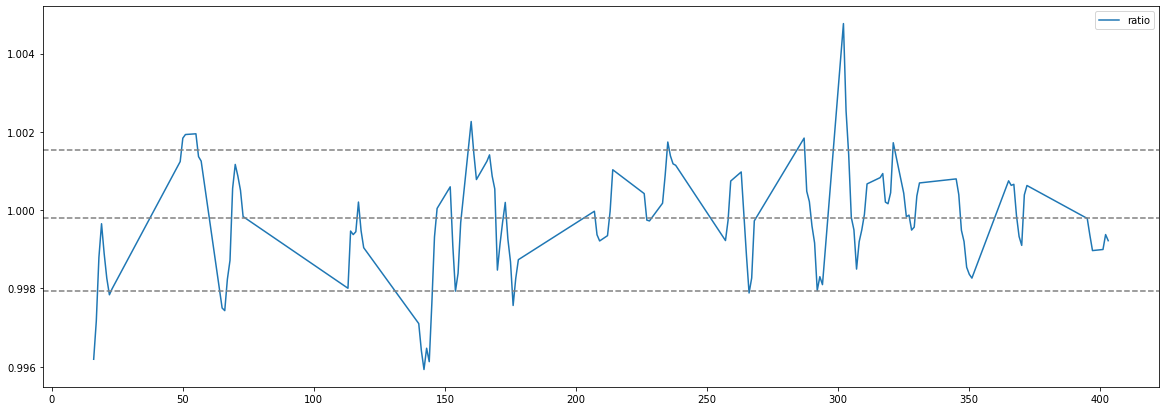

In [23]:
# visual look at ratio column
plt.rcParams["figure.figsize"] =  (20,7)

df['ratio'].head(500).dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--');
# can see ratio move around mean

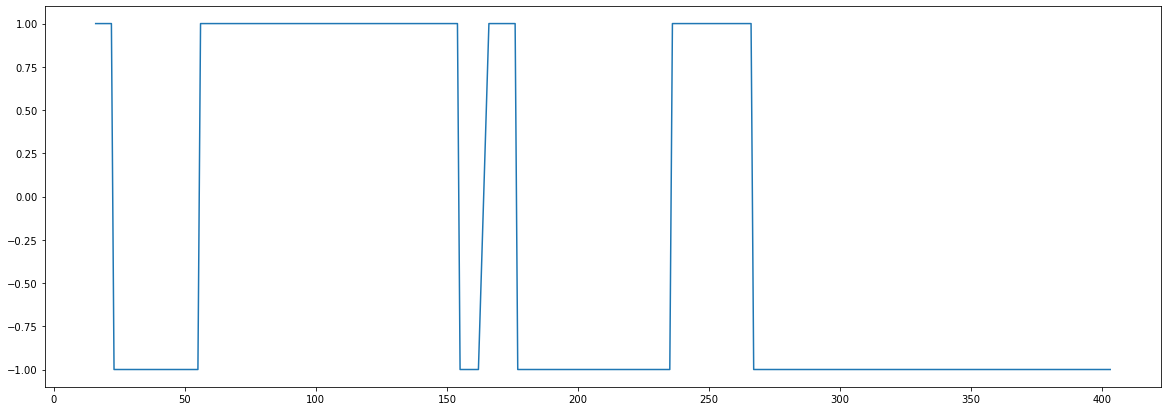

In [24]:
# df.position.dropna().plot()
plt.plot(df.head(2500).position.dropna())
plt.rcParams["figure.figsize"] = (20,7)


In [25]:
# plt.rcParams["figure.figsize"] =  (30,10)
# plt.plot(df['close'].tail(300).dropna(), label= "BTC-PERP")
# plt.plot((df['close']), (np.where(df.position > -1)), 'v', color="r", markersize=10)
# plt.plot((df['close']), (np.where(df.position < 0)),  '^', color="g", markersize=10)


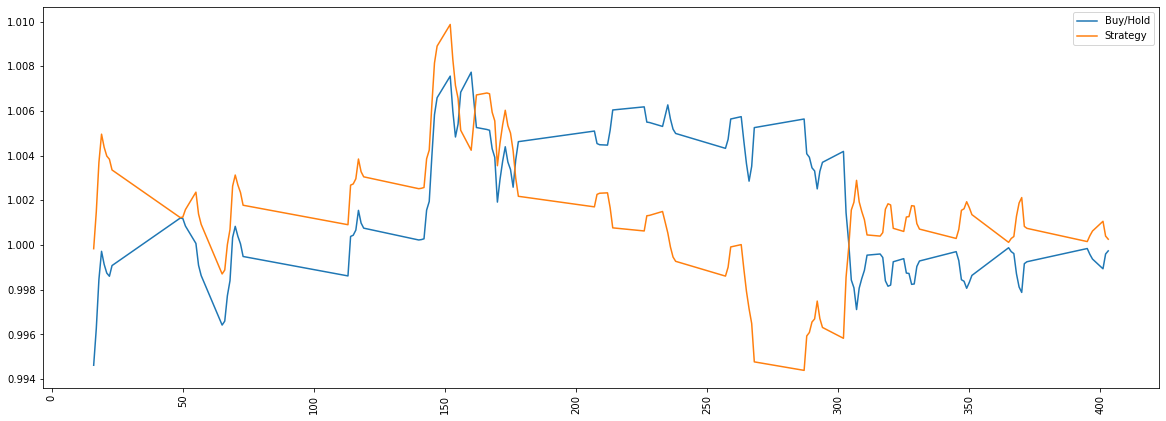

In [26]:
plt.plot(np.exp(df['returns'].tail(5000).dropna()).cumprod(), label='Buy/Hold')
plt.plot(np.exp(df['strat_return'].tail(5000).dropna()).cumprod(), label='Strategy')
plt.xticks(rotation=90)
plt.legend();

In [27]:
# # final value for each column

# print("Returns over time period specified within api call: ")
# marketR = np.exp(df['returns'].dropna()).cumprod().iloc[-1]-1
# stratR = np.exp(df['strat_return'].dropna()).cumprod().iloc[-1]-1
# percentageM = "{:.0%}".format(marketR)
# percentageS = "{:.0%}".format(stratR)
# print('Market: ', percentageM, 'Strat: ', percentageS)
# final value for each column
print("Returns over time period specified within api call: ")
print(np.exp(df['returns'].tail(5000).dropna()).cumprod().iloc[-1] -1)
print(np.exp(df['strat_return'].tail(5000).dropna()).cumprod().iloc[-1] -1)

Returns over time period specified within api call: 
-0.005377476661527991
-0.00016338683445127344


In [28]:
# Set initial capital
initial_capital = float(22000.0)

# Create df positions
positions = pd.DataFrame(index=df.startTime.index).fillna(0.0)


# Buy 2 BTC
positions['BTC-PERP'] = 1.5*df['position']

# Initilize portfolio w value owned
portfolio = positions.multiply(df['close'], axis=0)

# Store diff in shares owned
pos_diff = positions.diff()

# Add 'holdings' to portfolio
portfolio['holdings'] = (positions.multiply(df['close'], axis=0)).sum(axis=1)

# Add 'cash' to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(df['close'], axis=0)).sum(axis=1).cumsum()

# Add 'total' to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add 'returns' to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

portfolio['startTime'] = df['startTime']

In [34]:
portfolio

,BTC-PERP,holdings,cash,total,returns,startTime
403,-86127.0,-86127.0,22000.0,-64127.0,NaN,2021-10-11T17:56:00+00:00
402,-86115.0,-86115.0,22000.0,-64115.0,-0.000187,2021-10-11T17:55:00+00:00
401,-86058.0,-86058.0,22000.0,-64058.0,-0.000889,2021-10-11T17:54:00+00:00
397,-85980.0,-85980.0,22000.0,-63980.0,-0.001218,2021-10-11T17:50:00+00:00
396,-85998.0,-85998.0,22000.0,-63998.0,0.000281,2021-10-11T17:49:00+00:00
...,...,...,...,...,...,...
20,84690.0,84690.0,-148784.0,-64094.0,-0.000515,2021-10-11T11:33:00+00:00
19,84739.5,84739.5,-148784.0,-64044.5,-0.000772,2021-10-11T11:32:00+00:00
18,84633.0,84633.0,-148784.0,-64151.0,0.001663,2021-10-11T11:31:00+00:00
17,84447.0,84447.0,-148784.0,-64337.0,0.002899,2021-10-11T11:30:00+00:00


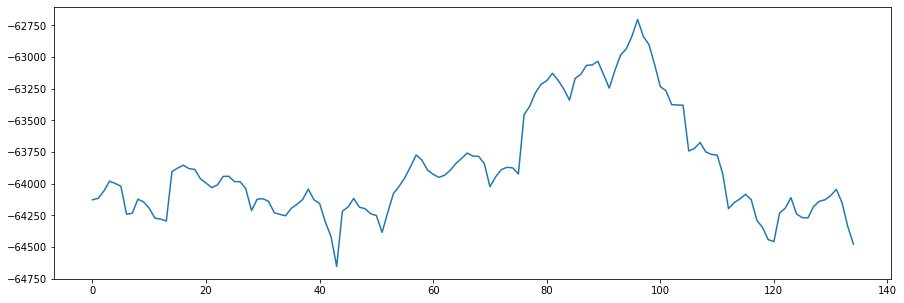

In [30]:

plt.rcParams["figure.figsize"] = (15,5)

x = portfolio['startTime']
y = portfolio['total']
values = range(len(x))
plt.plot(values,y)


# Show the plot
plt.show()

In [31]:
# df = add_all_ta_features(
#     df, open="open", high="high", low="low", close="close", volume="volume")
# df